### Import packages

In [32]:
from keras.models import Model, Sequential, model_from_json,load_model
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.preprocessing.image import load_img, save_img, img_to_array,ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.callbacks import History, EarlyStopping
import keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from scipy.misc import imresize
import os
import PIL
from skimage.transform import resize
from sklearn.metrics import accuracy_score, confusion_matrix
import pickle
from lime import lime_image
import lime
from skimage.segmentation import mark_boundaries
import imageio
import seaborn as sns
plt.style.use('ggplot')

### Define functions

In [3]:
def instantiate_model(numtrainable,num_dense = 120):
    """Instantiates the VGG Facial recognition model. 
    Removes the last layer from pre-trained model.
    Adds a new Dense() layer with num_dense nodes.
    Adds a final Dense(2) layer.
    Sets the last numtrainable layers as trainable, and fixes the others. """
    
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    model.load_weights('vgg_face_weights.h5')
    
    hidden = Dense(num_dense, activation='relu')(model.layers[-2].output)
    out = Dense(2, activation='softmax')(hidden)
    model2 = Model(input=model.layers[0].input, output=out)
    model = model2
    layer_count = 0
    for layer in model.layers:
        layer_count = layer_count+1
    print(layer_count)
    for l in range(layer_count):
        model.layers[l].trainable=True
    for l in range(layer_count-num_trainable):
        model.layers[l].trainable=False

    return model

In [4]:
def create_collage2(badAJ, badPJ,widthin=600,heightin=300,cols=5,rows=5): 
    """Creates a collage for misclassified images only"""
    
    for zz in [0,1]:
        if zz == 0:
            bads = badPJ
        else:
            bads = badAJ
        lenP = len(bads)
        if lenP < 1:
            continue
        cols = min(5,lenP)               
        rows = max(1,lenP//cols) 
        width = int(widthin / 5*cols)
        height = int(rows*(width/cols))       
        thumbnail_width = width//cols
        thumbnail_height = height//rows
        size = thumbnail_width, thumbnail_height
        new_im = Image.new('RGB', (width, height))
        ims = []  
        for p in bads:
            im = Image.fromarray(np.uint8(p))
            im.thumbnail(size)
            ims.append(im)
        i,x,y = 0,0,0
        for col in range(cols):
            for row in range(rows):
                tmp = ims[i]
                new_im.paste(tmp, (x, y))
                i += 1
                y += thumbnail_height
            x += thumbnail_width
            y = 0

        if zz == 0:
            print('Thinks Paul is Anthony ====== ')
        else:
            print('Thinks Anthony is Paul ====== ')
        plot_image(new_im)

In [5]:
def create_collage(width, height, path,name,collage_file,numimages,ims_in,numcols=14,widthin = 600):
    """Creates a collage for all input images in path"""
    
    print('Collage for ',name,' from ',path)
    
    cols = min(numcols,numimages)               
    rows = int(np.ceil(numimages/numcols)) 
    width = int(widthin / numcols*cols)
    height = int((rows)*(width/cols))
    thumbnail_width = width//cols
    thumbnail_height = height//rows
    size = thumbnail_width, thumbnail_height
    new_im = Image.new('RGB', (width, height))
    ims = []
    for p in ims_in:
        im = Image.fromarray(np.uint8(p))
        im.thumbnail(size)
        ims.append(im)
    i,x,y = 0,0,0
    for col in range(cols):
        for row in range(rows):
            try:
                tmp = ims[i]
            except:
                break
            new_im.paste(tmp, (x, y))
            i += 1
            y += thumbnail_height
        x += thumbnail_width
        y = 0

    new_im.save(collage_file)
    plot_image(new_im)

In [6]:
def plot_image(image):
    """Displays image"""
    image = np.clip(image, 0.0, 255.0)
    image = image.astype(np.uint8)
    display(PIL.Image.fromarray(image))
    
def resize_im(im,sq):
    """Resize image to 224x224, for input into face model"""
    try:
        width,height,col = im.shape
    except:
        col = 3
        width,height = im.shape
        im = [im,im,im]
    assert width == height    
    if width != sq:
        im_out = imresize(im, (sq,sq,col), interp='bilinear', mode=None)
    else:
        im_out = im
    return im_out

def getXY(path,sq=224):
    """Gets the images from path, for AJ and PJ.
    Returns X and Y to be fit to model.
    X is ndarray = (# images) x 224 x 224 x 3
    Y is ndarray = (# images) x 2 """
    
    path_to_dataPJ = path + 'PJ/'
    path_to_dataAJ = path + 'AJ/'
    PJfiles = os.listdir(path_to_dataPJ)
    AJfiles = os.listdir(path_to_dataAJ)
    trainy = []
    num_images = 0
    for i in range(len(PJfiles)):
        if PJfiles[i] == '.DS_Store':
            continue
        num_images += 1
    for i in range(len(AJfiles)):
        if AJfiles[i] == '.DS_Store':
            continue
        num_images += 1
    print(path,' Number of images: ',num_images)
    trainX = np.ndarray([num_images,sq,sq,3])
    counter=0
    for i in range(len(PJfiles)):        
        tmp_file = path_to_dataPJ + PJfiles[i]
        if PJfiles[i] == '.DS_Store':
            continue
        #print(tmp_file)
        tmp = imread(tmp_file)      
        tmp2 = resize_im(tmp,sq)
        trainX[counter,:,:,:] = tmp2[:,:,:3]
        counter += 1
        trainy.append(1)

    for i in range(len(AJfiles)):        
        tmp_file = path_to_dataAJ + AJfiles[i]
        if AJfiles[i] == '.DS_Store':
            continue
        tmp = imread(tmp_file)
        tmp2 = resize_im(tmp,sq)
        trainX[counter,:,:,:] = tmp2[:,:,:3]
        counter += 1
        trainy.append(0)
        
    Y = to_categorical(trainy)
    X = trainX.reshape(num_images,sq,sq,3)
    print('Done importing ',str(num_images),' images from ... ',path)
    return X, Y,int(num_images/2)

def show_errors(predY, trueY,X,which):
    """Displays confusion matrix for input predY and trueY, 
    and calls collage2 to show misclassified images"""
    
    cm = confusion_matrix(trueY,predY)
    print(' =====================',which, ' =====================')
    print(cm)
    c = 0
    names = ['Anthony','Paul']
    badimsAJ = []
    badimsPJ = []
    for i,j in list(zip(predY,trueY)):
        k = i-j
        if k != 0:
            if j == 1: # is actually PJ
                badimsPJ.append(X[c])
            else:
                badimsAJ.append(X[c])
        c += 1  
    create_collage2(badimsAJ,badimsPJ)
    
def plot_history(history,wid=9,height=4.5):
    """Plot history of training of input model history"""
    try:
        history=history[0]
    except:
        pass
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(wid, height), tight_layout=True)
    ax1.plot(history.history['acc'])#,color='r')
    ax1.plot(history.history['val_acc'])#,color='k')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'validation'], loc='upper left')

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
def round_int(in1,in2,in3,in4):
    return in1.round().astype(int),in2.round().astype(int),in3.round().astype(int),in4.round().astype(int)

def get_scores(trainY2,train_predY2,testY2,test_predY2,testY3=[0],test_predY3=[0]):
    score_train = accuracy_score(trainY2,train_predY2)
    score_test = accuracy_score(testY2,test_predY2)
    if len(testY3) == 1:
        print('Training accuracy: ',score_train, ' , Validation accuracy:',score_test)
        return score_train,score_test
    else:
        score_test2 = accuracy_score(testY3,test_predY3)
        print('Training accuracy: ',score_train, ' , Validation accuracy:',score_test,' , Testing accuracy:',score_test2)
        return score_train,score_test,score_test2
    

def get_predictions(pckl_save,model,testX,trainX):
                
    if os.path.isfile(pckl_save) == False: 
        test_predY = model.predict(testX[:])[:,1]
        train_predY = model.predict(trainX[:])[:,1]
        with open(pckl_save, 'wb') as tmp:
            pickle.dump([test_predY,train_predY], tmp)                    
    else:
        with open(pckl_save, 'rb') as tmp:
            [test_predY,train_predY] = pickle.load(tmp)  
    
    return test_predY,train_predY

def my_makedir(path):
    if not os.path.exists(path):
        os.makedirs(path)
    return path

In [7]:
def findCosineDistance(source_representation, test_representation):
    """Return cosine distance between 2 vectors"""
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))
 
def findEuclideanDistance(source_representation, test_representation):
    """Return Euclidean distance between 2 vectors"""
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

def verifyFace(img1, img2, mod):
    """Compares 2 faces: img1 and img2, using model mod"""
    
    img1_representation = mod.predict(img1)[0,:]
    img2_representation = mod.predict(img2)[0,:]

    len = img1_representation.shape[0]
    cosine_similarity = findCosineDistance(img1_representation, img2_representation)
    euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)
    
    print("Cosine similarity: ",cosine_similarity)
    print("Euclidean distance: ",euclidean_distance)
    
    if(cosine_similarity < epsilon):
        print("verified... they are same person")
    else:
        print("unverified! they are not same person!")
    
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(256-np.squeeze(img1))
    plt.xticks([]); plt.yticks([])
    f.add_subplot(1,2, 2)
    plt.imshow(256-np.squeeze(img2))
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    print("-----------------------------------------")
    return img1_representation, img2_representation,cosine_similarity,euclidean_distance 

## Import images

In [8]:
path_training = 'Training2/'
path_val = 'Validation/'
path_testing = 'Testing/'
trainX, trainY,numtrain = getXY(path_training)
valX, valY,numval = getXY(path_val)  
testX, testY,numtest = getXY(path_testing)  

Training2/  Number of images:  236


/Users/Anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Done importing  236  images from ...  Training2/
Validation/  Number of images:  54
Done importing  54  images from ...  Validation/
Testing/  Number of images:  66
Done importing  66  images from ...  Testing/


Collage for  AJ  from  Training2/


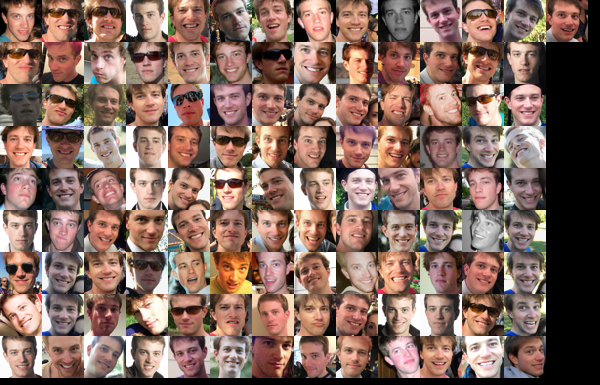

Collage for  PJ  from  Training2/


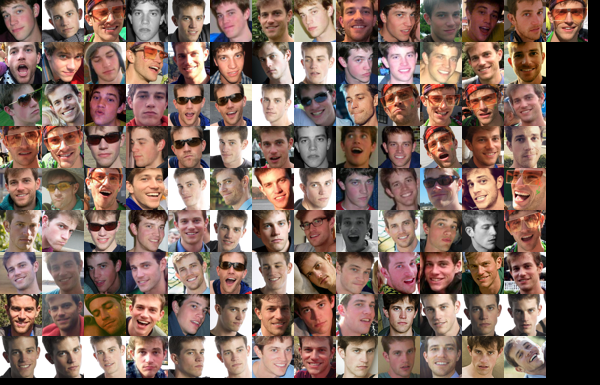

Collage for  AJ  from  Validation/


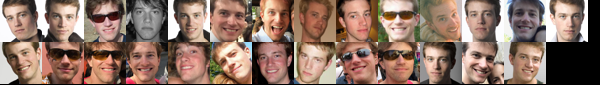

Collage for  PJ  from  Validation/


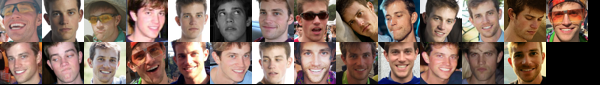

Collage for  AJ  from  Testing/


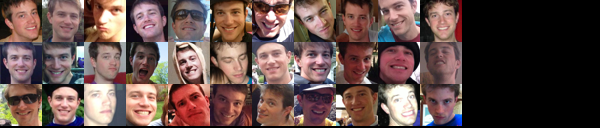

Collage for  PJ  from  Testing/


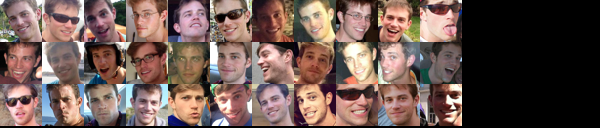

In [ ]:
create_collage(700, 500, path_training , 'AJ', 'collage.jpg',numtrain,trainX[numtrain:,:,:,:])
create_collage(700, 500, path_training , 'PJ', 'collage.jpg',numtrain,trainX[0:numtrain,:,:,:])
create_collage(450, 300, path_val, 'AJ', 'collage.jpg',numval,valX[numval:,:,:,:])
create_collage(450, 300, path_val , 'PJ', 'collage.jpg',numval,valX[0:numval,:,:,:])
create_collage(450, 300, path_testing, 'AJ', 'collage.jpg',numtest,testX[numtest:,:,:,:])
create_collage(450, 300, path_testing , 'PJ', 'collage.jpg',numtest,testX[0:numtest,:,:,:])

## Train Model - Iteration #1
I tried setting more or less layers to untrainable (last i layers in model are trainable). These runs did not converge.

Training/  Number of images:  172


/Users/Anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Done importing  172  images from ...  Training/
SGD/twinmodel4.h5
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


/Users/Anthony/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


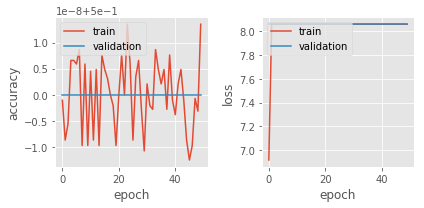

Training accuracy:  0.5  , Validation accuracy: 0.5
SGD/twinmodel5.h5


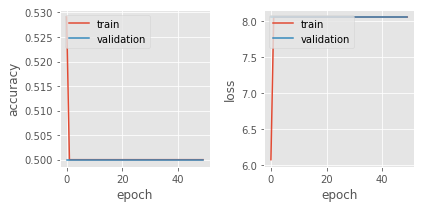

Training accuracy:  0.5  , Validation accuracy: 0.5
SGD/twinmodel6.h5


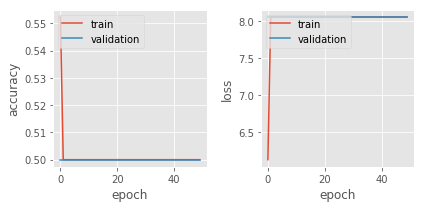

Training accuracy:  0.5  , Validation accuracy: 0.5
SGD/twinmodel7.h5


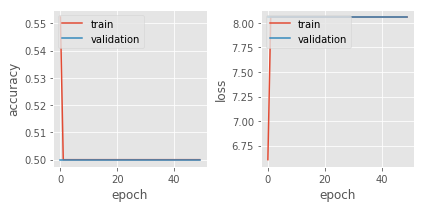

Training accuracy:  0.5  , Validation accuracy: 0.5
SGD/twinmodel8.h5


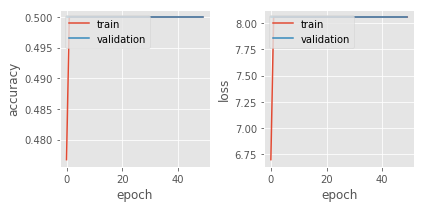

Training accuracy:  0.5  , Validation accuracy: 0.5
SGD/twinmodel9.h5


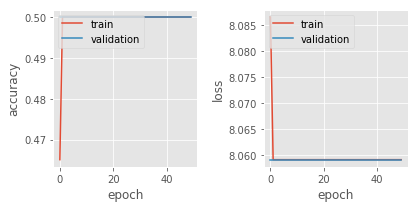

Training accuracy:  0.5  , Validation accuracy: 0.5


In [ ]:
path_training = 'Training/'
trainX, trainY,numtrain = getXY(path_training)
this_folder = my_makedir('SGD/')
for i in [4,5,6,7,8,9]:
    file_save = this_folder + 'twinmodel' + str(i) + '.h5'
    pckl_save_hist = this_folder + 'twinmodel'+str(i)+'hist.h5'
    pckl_save = this_folder + 'twinmodel_pred' + str(i) + '.pckl'
    print(file_save)
    if os.path.isfile(file_save) == False:
        model = instantiate_model(i)
        #model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
        model.compile(optimizer=keras.optimizers.SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False),
                      loss='categorical_crossentropy',metrics=['accuracy'])
        history = model.fit(trainX, trainY, batch_size=50, epochs=50,shuffle=True,validation_data=(valX, valY))
                
        model.save(file_save)        
        tmp = open(pckl_save_hist, 'wb')
        pickle.dump([history], tmp)
        tmp.close()
    else:
        model = load_model(file_save)
        tmp = open(pckl_save_hist, 'rb')
        history = pickle.load(tmp)
        tmp.close()   
    
    val_predY,train_predY = get_predictions(pckl_save,model,valX,trainX) 
        
    plot_history(history,wid=6,height=3)    
    val_predY2,valY2,train_predY2,trainY2 = round_int(val_predY,valY[:,1],train_predY,trainY[:,1])
    score_train,score_val = get_scores(trainY2,train_predY2,valY2,val_predY2)

## Train Model - Iteration #2
In addition to varying the number of trainable layers (i), I varied the learning rate (lr), and the number of nodes in the penultimate layer (num_dense).
I include an EarlyStopping condition, with a patience of 4.
These runs did  converge.

Training2/  Number of images:  236


/Users/Anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Done importing  236  images from ...  Training2/
Experiment3/twinmodel3_0.001_10.h5 , i:  3 , lr:  0.001  num_dense:  10


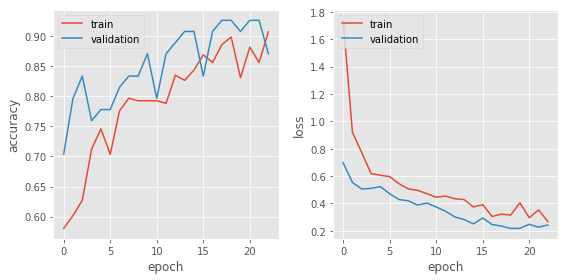

Training accuracy:  0.9449152542372882  , Validation accuracy: 0.8703703703703703
 ===================== Training  =====================
[[116   2]
 [ 11 107]]
Thinks Paul is Anthony ====== 


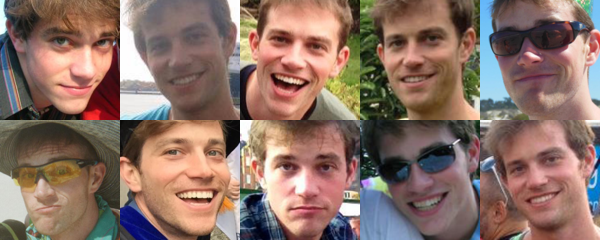

Thinks Anthony is Paul ====== 


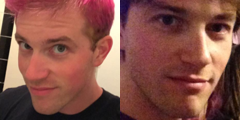

 ===================== Validation  =====================
[[24  3]
 [ 4 23]]
Thinks Paul is Anthony ====== 


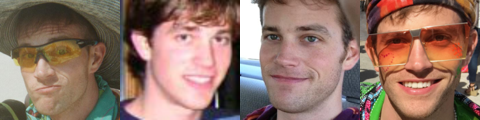

Thinks Anthony is Paul ====== 


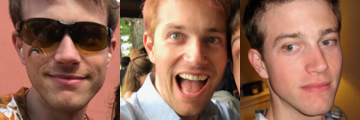

Experiment3/twinmodel3_0.001_50.h5 , i:  3 , lr:  0.001  num_dense:  50


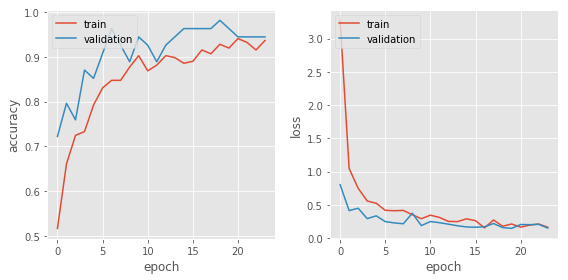

Training accuracy:  0.9788135593220338  , Validation accuracy: 0.9444444444444444
 ===================== Training  =====================
[[117   1]
 [  4 114]]
Thinks Paul is Anthony ====== 


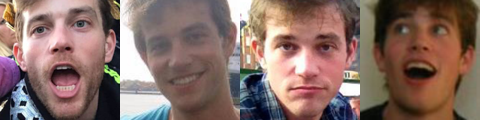

Thinks Anthony is Paul ====== 


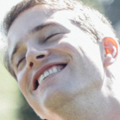

 ===================== Validation  =====================
[[25  2]
 [ 1 26]]
Thinks Paul is Anthony ====== 


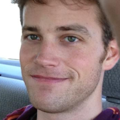

Thinks Anthony is Paul ====== 


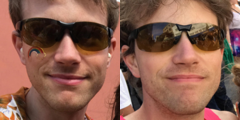

Experiment3/twinmodel3_0.001_100.h5 , i:  3 , lr:  0.001  num_dense:  100


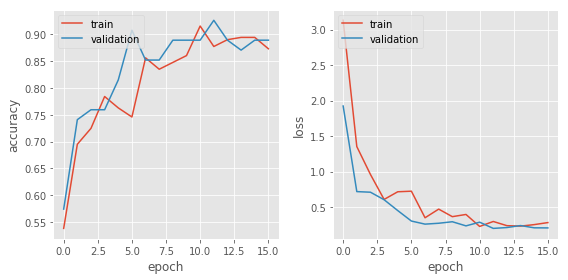

Training accuracy:  0.9703389830508474  , Validation accuracy: 0.8888888888888888
 ===================== Training  =====================
[[118   0]
 [  7 111]]
Thinks Paul is Anthony ====== 


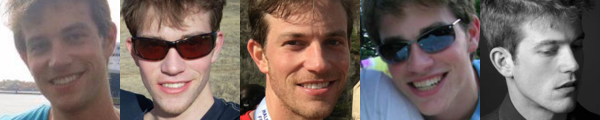

 ===================== Validation  =====================
[[25  2]
 [ 4 23]]
Thinks Paul is Anthony ====== 


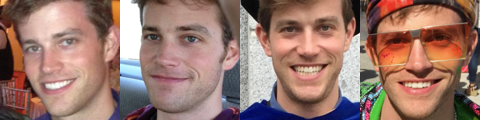

Thinks Anthony is Paul ====== 


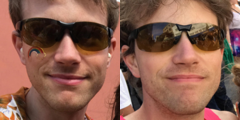

Experiment3/twinmodel3_0.001_200.h5 , i:  3 , lr:  0.001  num_dense:  200


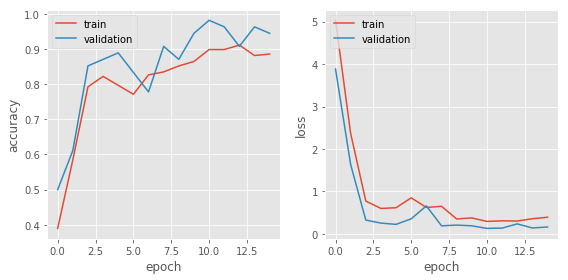

Training accuracy:  0.9788135593220338  , Validation accuracy: 0.9444444444444444
 ===================== Training  =====================
[[114   4]
 [  1 117]]
Thinks Paul is Anthony ====== 


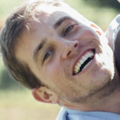

Thinks Anthony is Paul ====== 


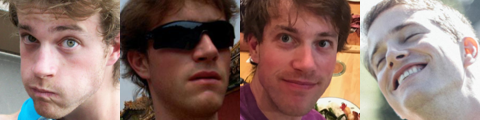

 ===================== Validation  =====================
[[24  3]
 [ 0 27]]
Thinks Anthony is Paul ====== 


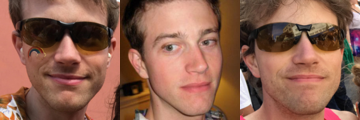

Experiment3/twinmodel4_0.001_10.h5 , i:  4 , lr:  0.001  num_dense:  10


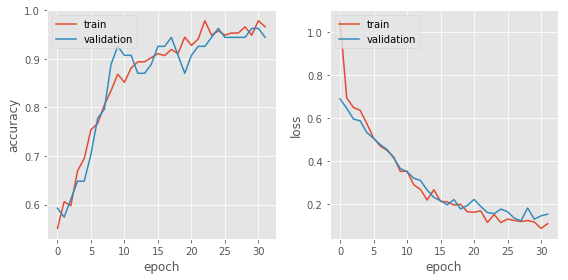

Training accuracy:  0.9915254237288136  , Validation accuracy: 0.9444444444444444
 ===================== Training  =====================
[[116   2]
 [  0 118]]
Thinks Anthony is Paul ====== 


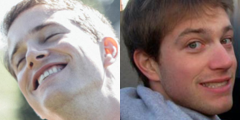

 ===================== Validation  =====================
[[24  3]
 [ 0 27]]
Thinks Anthony is Paul ====== 


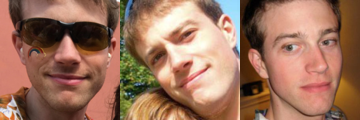

Experiment3/twinmodel4_0.001_50.h5 , i:  4 , lr:  0.001  num_dense:  50


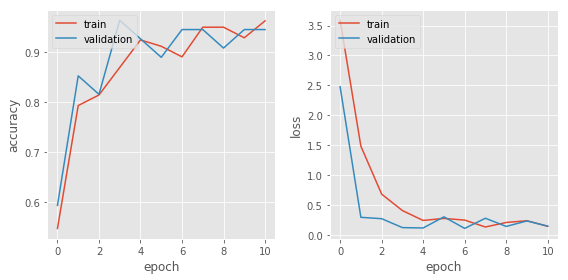

Training accuracy:  1.0  , Validation accuracy: 0.9444444444444444
 ===================== Training  =====================
[[118   0]
 [  0 118]]
 ===================== Validation  =====================
[[24  3]
 [ 0 27]]
Thinks Anthony is Paul ====== 


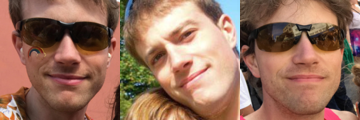

Experiment3/twinmodel4_0.001_100.h5 , i:  4 , lr:  0.001  num_dense:  100


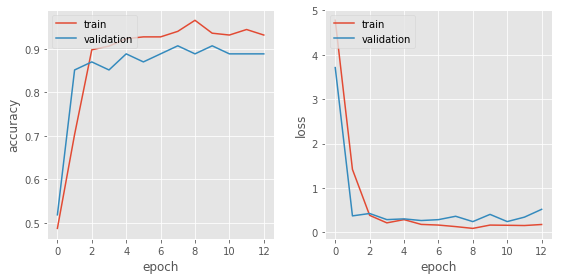

Training accuracy:  0.9872881355932204  , Validation accuracy: 0.8888888888888888
 ===================== Training  =====================
[[115   3]
 [  0 118]]
Thinks Anthony is Paul ====== 


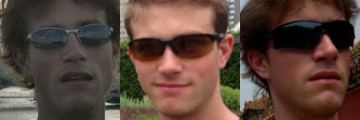

 ===================== Validation  =====================
[[21  6]
 [ 0 27]]
Thinks Anthony is Paul ====== 


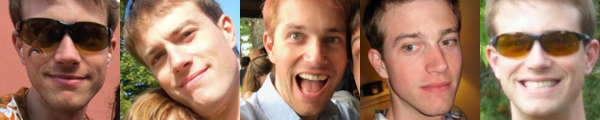

Experiment3/twinmodel4_0.001_200.h5 , i:  4 , lr:  0.001  num_dense:  200


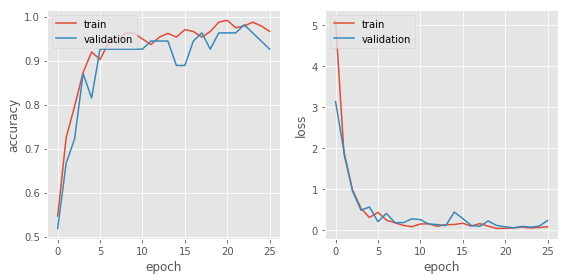

Training accuracy:  1.0  , Validation accuracy: 0.9259259259259259
 ===================== Training  =====================
[[118   0]
 [  0 118]]
 ===================== Validation  =====================
[[23  4]
 [ 0 27]]
Thinks Anthony is Paul ====== 


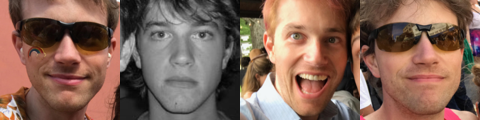

Experiment3/twinmodel5_0.001_10.h5 , i:  5 , lr:  0.001  num_dense:  10


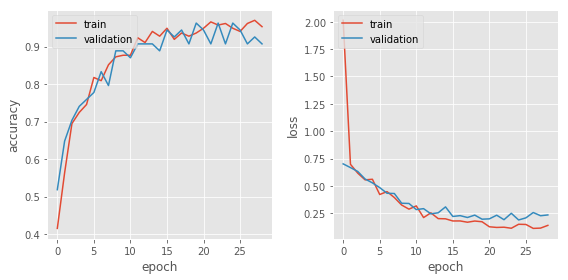

Training accuracy:  0.9957627118644068  , Validation accuracy: 0.9074074074074074
 ===================== Training  =====================
[[117   1]
 [  0 118]]
Thinks Anthony is Paul ====== 


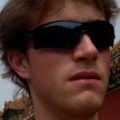

 ===================== Validation  =====================
[[22  5]
 [ 0 27]]
Thinks Anthony is Paul ====== 


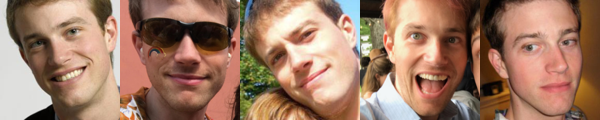

Experiment3/twinmodel5_0.001_50.h5 , i:  5 , lr:  0.001  num_dense:  50


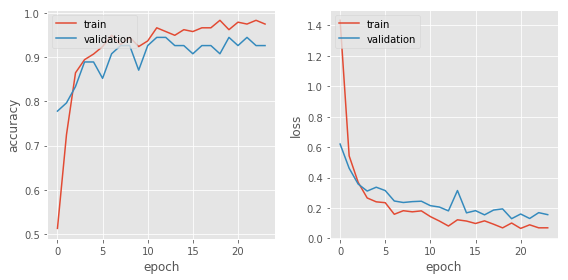

Training accuracy:  1.0  , Validation accuracy: 0.9259259259259259
 ===================== Training  =====================
[[118   0]
 [  0 118]]
 ===================== Validation  =====================
[[24  3]
 [ 1 26]]
Thinks Paul is Anthony ====== 


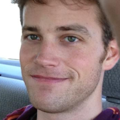

Thinks Anthony is Paul ====== 


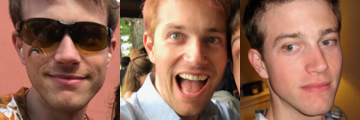

Experiment3/twinmodel5_0.001_100.h5 , i:  5 , lr:  0.001  num_dense:  100


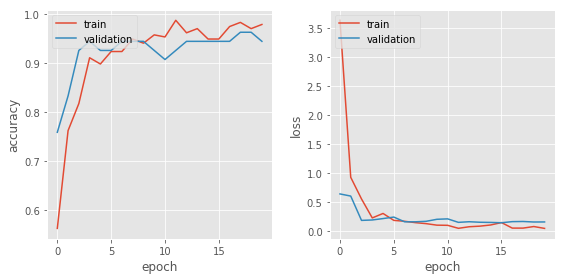

Training accuracy:  1.0  , Validation accuracy: 0.9444444444444444
 ===================== Training  =====================
[[118   0]
 [  0 118]]
 ===================== Validation  =====================
[[25  2]
 [ 1 26]]
Thinks Paul is Anthony ====== 


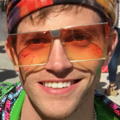

Thinks Anthony is Paul ====== 


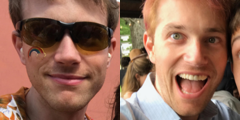

Experiment3/twinmodel5_0.001_200.h5 , i:  5 , lr:  0.001  num_dense:  200


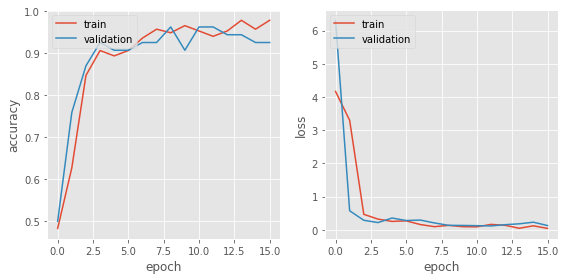

Training accuracy:  1.0  , Validation accuracy: 0.9259259259259259
 ===================== Training  =====================
[[118   0]
 [  0 118]]
 ===================== Validation  =====================
[[23  4]
 [ 0 27]]
Thinks Anthony is Paul ====== 


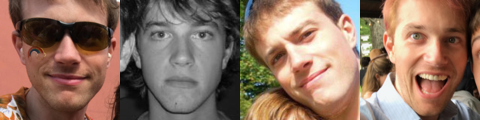

Experiment3/twinmodel6_0.001_10.h5 , i:  6 , lr:  0.001  num_dense:  10


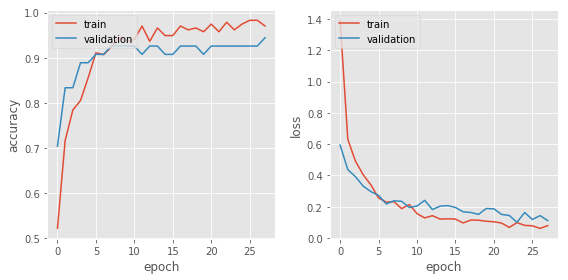

Training accuracy:  1.0  , Validation accuracy: 0.9444444444444444
 ===================== Training  =====================
[[118   0]
 [  0 118]]
 ===================== Validation  =====================
[[24  3]
 [ 0 27]]
Thinks Anthony is Paul ====== 


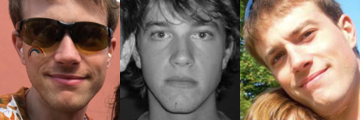

Experiment3/twinmodel6_0.001_50.h5 , i:  6 , lr:  0.001  num_dense:  50


In [ ]:
path_training = 'Training2/'
trainX, trainY,numtrain = getXY(path_training)   
early_stopping = EarlyStopping(monitor='val_loss', patience=4, mode='auto')
this_folder = my_makedir('Experiment3/')
for i in [3,4,5,6]:
    for lr in [.001]:
        for num_dense in [10,50,100,200]:
            file_save = this_folder + 'twinmodel' + str(i) + '_' + str(lr) + '_' + str(num_dense) + '.h5'
            pckl_save_hist = this_folder + 'twinmodel'+str(i)+ '_' + str(lr) + '_' + str(num_dense)+'hist.pckl'
            pckl_save = this_folder + 'twinmodel_pred' + str(i)+ '_' + str(lr) + '_' + str(num_dense) + '.pckl'
            print(file_save,', i: ',i,', lr: ',lr,' num_dense: ',num_dense )
            if os.path.isfile(file_save) == False:
                history = History()
                model = instantiate_model(i,num_dense=num_dense)
                model.compile(optimizer=keras.optimizers.SGD(lr=lr, momentum=0.0, decay=0.00, nesterov=False),
                              loss='categorical_crossentropy',metrics=['accuracy'])
                model.fit(trainX, trainY, batch_size=50, epochs=50,
                                    shuffle=True,validation_data=(valX, valY), callbacks=[history,early_stopping])
                model.save(file_save)        
                with open(pckl_save_hist, 'wb') as tmp:
                    pickle.dump([history], tmp)
            else:
                model = load_model(file_save)  
                with open(pckl_save_hist, 'rb') as tmp:
                    history = pickle.load(tmp)

            val_predY,train_predY = get_predictions(pckl_save,model,valX,trainX) 

            plot_history(history,8,4)                
            val_predY2,valY2,train_predY2,trainY2 = round_int(val_predY,valY[:,1],train_predY,trainY[:,1])
            score_train,score_val = get_scores(trainY2,train_predY2,valY2,val_predY2)
            show_errors(train_predY2,trainY2,trainX,'Training')
            show_errors(val_predY2,valY2,valX,'Validation')

## Train Model - Iteration #3
Finally, I varied the decay of the learning rate. I also increased the patience to 6.
These runs also converged.

Experiment4/twinmodel5_0.001_100_5e-06.h5 , i:  5 , lr:  0.001  num_dense:  100


/Users/Anthony/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


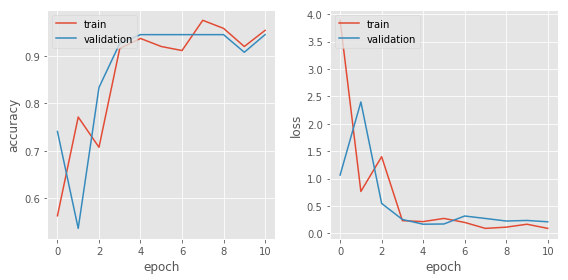

Training accuracy:  1.0  , Validation accuracy: 0.9444444444444444
 ===================== Training  =====================
[[118   0]
 [  0 118]]
 ===================== Validation  =====================
[[24  3]
 [ 0 27]]
Thinks Anthony is Paul ====== 


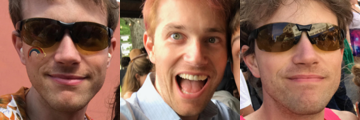

Experiment4/twinmodel5_0.001_100_1e-05.h5 , i:  5 , lr:  0.001  num_dense:  100


/Users/Anthony/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


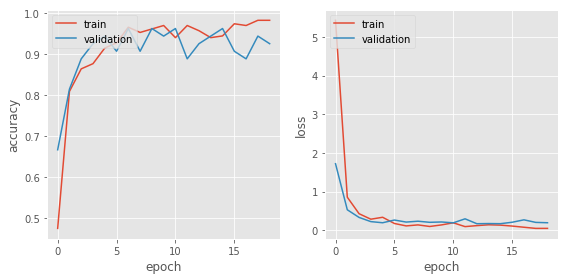

Training accuracy:  1.0  , Validation accuracy: 0.9259259259259259
 ===================== Training  =====================
[[118   0]
 [  0 118]]
 ===================== Validation  =====================
[[24  3]
 [ 1 26]]
Thinks Paul is Anthony ====== 


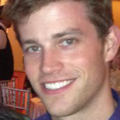

Thinks Anthony is Paul ====== 


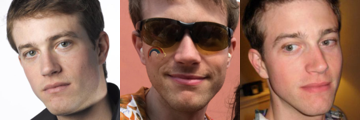

Experiment4/twinmodel5_0.001_100_2e-05.h5 , i:  5 , lr:  0.001  num_dense:  100


/Users/Anthony/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


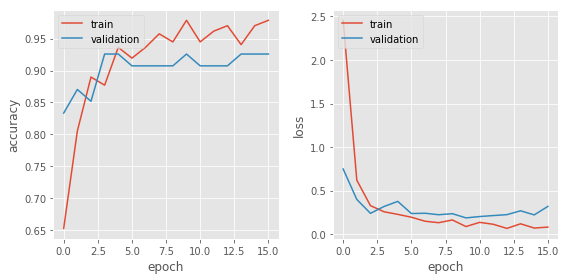

Training accuracy:  0.9957627118644068  , Validation accuracy: 0.9259259259259259
 ===================== Training  =====================
[[117   1]
 [  0 118]]
Thinks Anthony is Paul ====== 


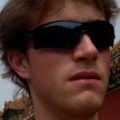

 ===================== Validation  =====================
[[23  4]
 [ 0 27]]
Thinks Anthony is Paul ====== 


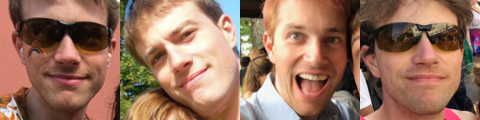

Experiment4/twinmodel5_0.001_100_4e-05.h5 , i:  5 , lr:  0.001  num_dense:  100


/Users/Anthony/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


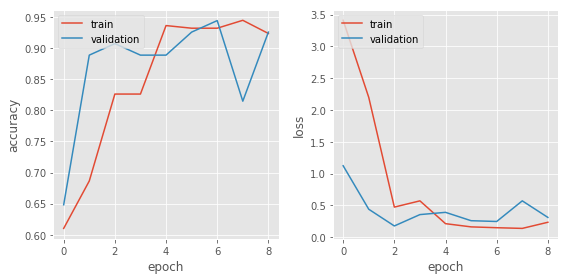

Training accuracy:  1.0  , Validation accuracy: 0.9259259259259259
 ===================== Training  =====================
[[118   0]
 [  0 118]]
 ===================== Validation  =====================
[[23  4]
 [ 0 27]]
Thinks Anthony is Paul ====== 


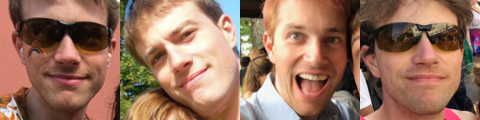

In [74]:
early_stopping = EarlyStopping(monitor='val_loss', patience=6, mode='auto')
this_folder = my_makedir('Experiment4/')
for i in [5]:
    for lr in [.001]:
        for num_dense in [100]:
            for decay in [.000005,.00001,.00002,.00004]:
                file_save = this_folder + 'twinmodel' + str(i) + '_' + str(lr) + '_' + str(num_dense)+ '_' + str(decay) + '.h5'
                pckl_save_hist = this_folder + 'twinmodel'+str(i)+ '_' + str(lr) + '_' + str(num_dense)+ '_' + str(decay)+'hist.pckl'
                pckl_save = this_folder + 'twinmodel_pred' + str(i)+ '_' + str(lr) + '_' + str(num_dense)+ '_' + str(decay) + '.pckl'
                print(file_save,', i: ',i,', lr: ',lr,' num_dense: ',num_dense )
                if os.path.isfile(file_save) == False:
                    history = History()
                    model = instantiate_model(i,num_dense=num_dense)
                    model.compile(optimizer=keras.optimizers.SGD(lr=lr, momentum=0.0, decay=decay, nesterov=False),
                                  loss='categorical_crossentropy',metrics=['accuracy'])
                    model.fit(trainX, trainY, batch_size=50, epochs=50,
                                        shuffle=True,validation_data=(valX, valY), callbacks=[history,early_stopping])

                    model.save(file_save)        
                    with open(pckl_save_hist, 'wb') as tmp:
                        pickle.dump([history], tmp)
                else:
                    model = load_model(file_save)
                    with open(pckl_save_hist, 'rb') as tmp:
                        history = pickle.load(tmp)

                val_predY,train_predY = get_predictions(pckl_save,model,valX,trainX) 
                        
                plot_history(history,8,4)
                val_predY2,valY2,train_predY2,trainY2 = round_int(val_predY,valY[:,1],train_predY,trainY[:,1])
                score_train,score_val = get_scores(trainY2,train_predY2,valY2,val_predY2)
                show_errors(train_predY2,trainY2,trainX,'Training')
                show_errors(val_predY2,valY2,valX,'Validation')

## Assessment of best model

<div class="span5 alert alert-success">
<p> Below we see the training history for the best model. It has a training accuracy of 100% and a validation accuracy of 94%. The final testing accuracy is 88%. It took 19 epochs to converge, with an EarlyStopping patience of 6 (minimizing val_loss).
  
In the validation set, there was one false PJ and two false AJs. In 2 out of 3 misclassifications, there were sunglasses that partially obstructed the face.

In the final testing set, there are 4 false PJs and 4 false AJs (shown below). In these misclassifications, the lighting is inconsistent or the faces are slightly unusual.
   </p>
</div>

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


/Users/Anthony/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


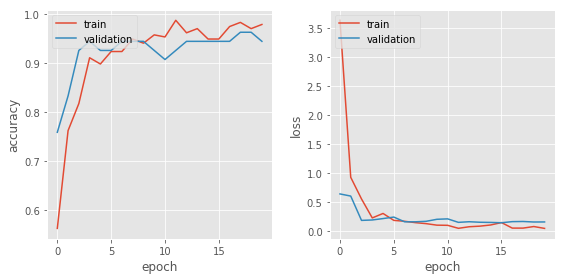

Training accuracy:  1.0  , Validation accuracy: 0.9444444444444444  , Testing accuracy: 0.8787878787878788
 ===================== Training  =====================
[[118   0]
 [  0 118]]
 ===================== Validation  =====================
[[25  2]
 [ 1 26]]
Thinks Paul is Anthony ====== 


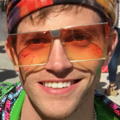

Thinks Anthony is Paul ====== 


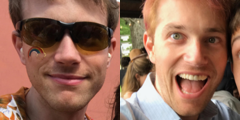

 ===================== Testing  =====================
[[29  4]
 [ 4 29]]
Thinks Paul is Anthony ====== 


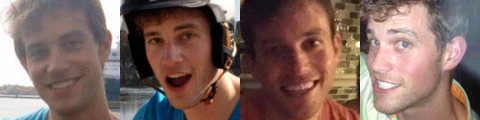

Thinks Anthony is Paul ====== 


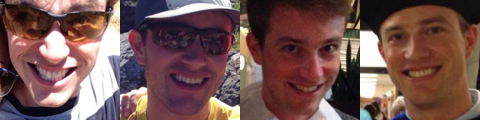

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_131_input (In (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d_131 (ZeroPadd (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_132 (ZeroPadd (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_162 (Conv2D)          (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_133 (ZeroPadd (None, 114, 114, 64)      0         
__________

In [9]:
# Load best model so far
bestfile = 'Experiment3/'
file_save = bestfile+'twinmodel5_0.001_100.h5'
pckl_save = bestfile+'twinmodel_pred5_0.001_100.pckl'
pckl_save_hist = bestfile+'twinmodel5_0.001_100hist.pckl'
model = load_model(file_save)
with open(pckl_save, 'rb') as tmp:
    [test_predY,train_predY] = pickle.load(tmp)
with open(pckl_save_hist, 'rb') as tmp:
    history = pickle.load(tmp)
val_predY,train_predY = get_predictions(pckl_save,model,valX,trainX) 
plot_history(history,8,4)
val_predY2,valY2,train_predY2,trainY2 = round_int(val_predY,valY[:,1],train_predY,trainY[:,1])

pckl_save_final_test = bestfile+'twinmodel_finaltest_pred5_0.001_100.pckl'
if os.path.isfile(pckl_save_final_test) == False: 
    finaltest_predY = model.predict(testX2[:])[:,1]    
    with open(pckl_save_final_test, 'wb') as tmp:
        pickle.dump([finaltest_predY], tmp)                    
else:
    with open(pckl_save_final_test, 'rb') as tmp:
        [finaltest_predY] = pickle.load(tmp)  
finaltest_predY2,testY2,_,_ = round_int(finaltest_predY,testY[:,1],train_predY,trainY[:,1])

score_train,score_val,score_test = get_scores(trainY2,train_predY2,valY2,val_predY2,testY2,finaltest_predY2)
show_errors(train_predY2,trainY2,trainX,'Training')
show_errors(val_predY2,valY2,valX,'Validation')
show_errors(finaltest_predY2,testY2,testX,'Testing')
model.summary()

In [10]:
# Compute ROC curve 
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
fpr2 = dict()
tpr2 = dict()
roc_auc = dict()
roc_auc2 = dict()
fpr_tr = dict()
tpr_tr = dict()
roc_auc_tr = dict()
n_classes = 2
y_pred = val_predY
y_pred_tr = train_predY
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(valY[:,1], y_pred[:])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    fpr2[i], tpr2[i], _ = roc_curve(testY[:,1], finaltest_predY[:])
    roc_auc2[i] = auc(fpr2[i], tpr2[i])
    
    fpr_tr[i], tpr_tr[i], _ = roc_curve(trainY[:,1], y_pred_tr[:])
    roc_auc_tr[i] = auc(fpr_tr[i], tpr_tr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(valY[:,1].ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
fpr2["micro"], tpr2["micro"], _ = roc_curve(testY[:,1].ravel(), finaltest_predY.ravel())
roc_auc2["micro"] = auc(fpr2["micro"], tpr2["micro"])
fpr_tr["micro"], tpr_tr["micro"], _ = roc_curve(trainY[:,1].ravel(), y_pred_tr.ravel())
roc_auc_tr["micro"] = auc(fpr_tr["micro"], tpr_tr["micro"])

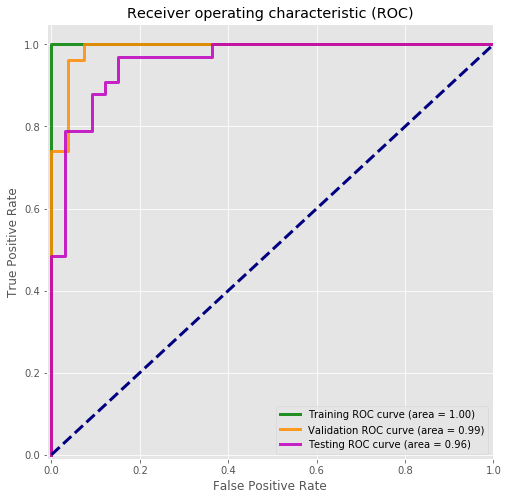

In [11]:
fig = plt.figure(figsize=(8, 8))
plt.plot(fpr_tr[0], tpr_tr[0], color='green',
         lw=3, label='Training ROC curve (area = %0.2f)' % roc_auc_tr[0],alpha=0.85)
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=3, label='Validation ROC curve (area = %0.2f)' % roc_auc[0],alpha=0.85)
plt.plot(fpr2[0], tpr2[0], color='m',
         lw=3, label='Testing ROC curve (area = %0.2f)' % roc_auc2[0],alpha=0.85)

plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.xlim([-.01, 1.0])
plt.ylim([-.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### LIME Analysis

<div class="span5 alert alert-success">
<p> Below, I attempt to explain why the model classified each face, using the LIME package (Local Interpretable Model-Agnostic Explanations).
   </p>
</div>

In [12]:
# Input each testing image through the LimeImageExplainer, and save the explanation variable into the LimeP folder.
lime = my_makedir('Lime/')
limep = my_makedir('LimeP/')
lims = []
for i in range(len(valX)):
    pckl_save = limep + 'testX_' + str(i) + '.pckl'
    if os.path.isfile(pckl_save) == False:
        explainertmp = lime_image.LimeImageExplainer()
        explanation = explainertmp.explain_instance(valX[i], 
                                                       model.predict, top_labels=2, hide_color=0, num_samples=100)
        with open(pckl_save,'wb') as tmp:
            pickle.dump([explanation],tmp)
    else:
        with open(pckl_save,'rb') as tmp:
            explanation = pickle.load(tmp)
            
    temp, mask = explanation[0].get_image_and_mask(0, positive_only=False, num_features=1000, hide_rest=False)
    im_save = lime + 'testX_' + str(i) + '.jpg'
    if os.path.isfile(im_save) == False:
        plot_image(mark_boundaries(temp / 2 + 0.5, mask))
        imageio.imwrite(im_save, temp.astype(np.uint8)) 
    lims.append(temp)

Collage for  PJ Lime  from  Validation/


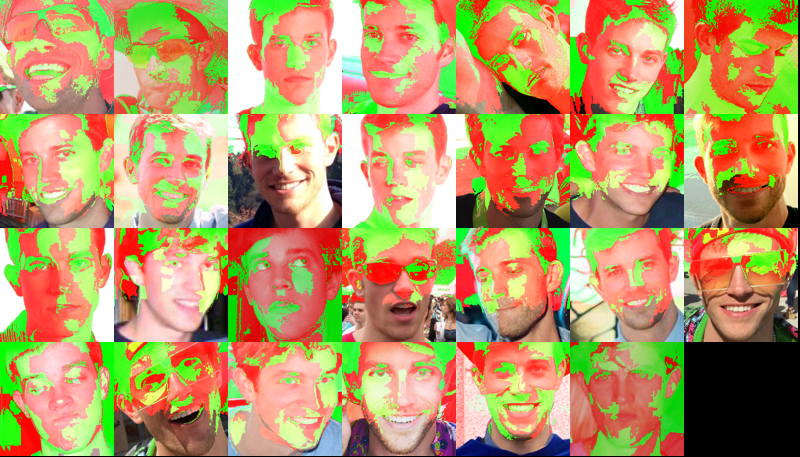

Collage for  AJ Lime  from  Validation/


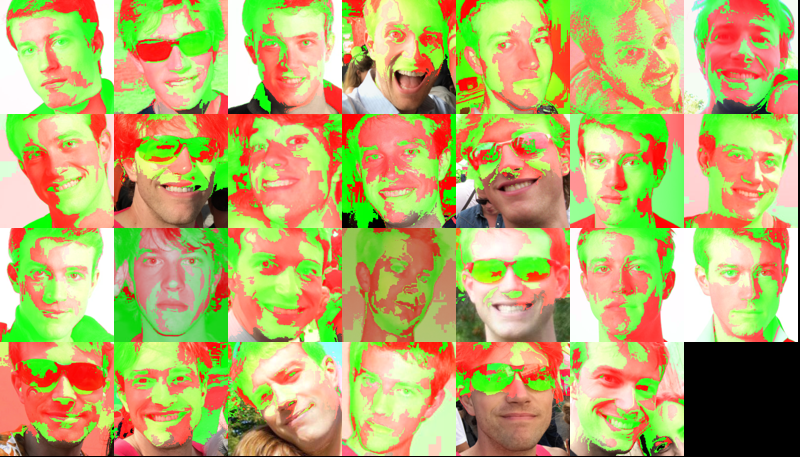

In [13]:
# Create a collage for PJ and AJ LIME results.
nval = int(len(valX)/2)
create_collage(1200, 1000, path_val , 'PJ Lime', 'collage_lims.jpg',nval,lims[:nval],numcols=7,widthin = 800)
create_collage(1200, 1000, path_val , 'AJ Lime', 'collage_lims.jpg',nval,lims[nval:],numcols=7,widthin = 800)

In [14]:
allred = []
allgreen = []
rat = []
for i in range(nval*2):
    reds = lims[i][:,:,0]
    greens = lims[i][:,:,1]    
    redsum = round(sum(sum(reds))/224/224/255,4)
    greensum = round(sum(sum(greens))/224/224/255,4)    
    allred.append(redsum)
    allgreen.append(greensum)
    rat.append(redsum/greensum)

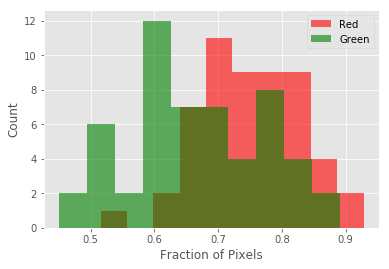

In [15]:
plt.hist(allred,alpha=0.6,color='r')
plt.hist(allgreen,alpha=0.6,color='g')
plt.xlabel('Fraction of Pixels')
plt.ylabel('Count')
plt.legend(['Red','Green'])

Text(0,0.5,'Count')

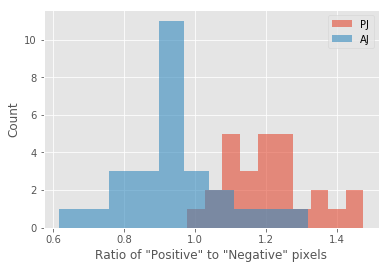

In [22]:
# Ratio of positive to negative pixel fraction, for both AJ and PJ
plt.hist(rat[:nval],alpha=0.6)
plt.hist(np.power(rat[nval:],-1),alpha=0.6)
plt.legend(['PJ','AJ'])
plt.xlabel('Ratio of "Positive" to "Negative" pixels')
plt.ylabel('Count')

In [28]:
# Average ratio for PJ
np.array(rat[:nval]).mean()

1.2087227262296556

In [30]:
# Average ratio for AJ
np.power(rat[nval:],-1).mean()

0.9416691456957127

<div class="span5 alert alert-success">
<p> Above, we see a histogram plot of the ratio of "positive" to "negative" pixels, for both PJ and AJ. In other words, in the images with a PJ label, the ratio of red to green pixels was between 1.0 and 1.5. But for AJ images, the equivalent ratio (green to red in this case) varied much more widely, between 0.6 and 1.3. 
    
It's unclear why exactly this would be the case, but it ultimately means that the model has an easier time recognizing PJ than AJ. This pattern has been consistent; nearly every model trained in this project resulted in more false AJs than false PJs. 

One explanation could be that the PJ images are "better," and this difference is due to chance in picking the images.

An alternative, though quite speculative, explanation is that AJ's face is essentially a subset of PJ's face. In other words, AJ's face could be more "generic" (fewer features), and that PJ's face can be obtained by adding features to AJ's face. Testing this theory is beyond the scope of this project, but it is an interesting concept.

   </p>
</div>


### Cosine Distance

PJ, img14


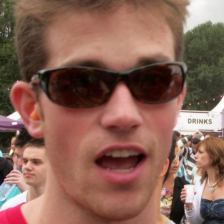

AJ, img30


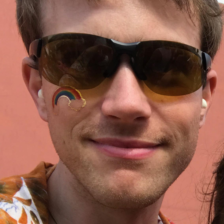

AJ, img31


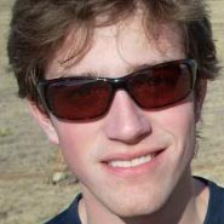

In [17]:
# Calculate the cosine distance between 3 vectors: the penultimate layer for img14, img30, and img31 
# (PJ, AJ, AJ, respectively)
img14 = np.ndarray([1,224,224,3])
img30 = np.ndarray([1,224,224,3])
img31 = np.ndarray([1,224,224,3])
img14[:,:,:,:] = valX[14,:,:,:]
img30[:,:,:,:] = valX[30,:,:,:]
img31[:,:,:,:] = valX[31,:,:,:]
print('PJ, img14')
plot_image(np.squeeze(img14))
print('AJ, img30')
plot_image(np.squeeze(img30))
print('AJ, img31')
plot_image(np.squeeze(img31))

In [18]:
epsilon = 0.40
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

Cosine similarity:  0.13973468542099
Euclidean distance:  21.714138
verified... they are same person


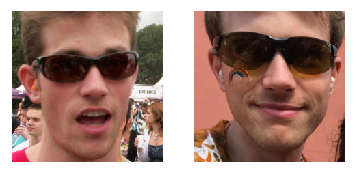

-----------------------------------------
Cosine similarity:  0.4106149673461914
Euclidean distance:  35.715675
unverified! they are not same person!


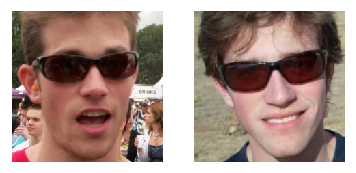

-----------------------------------------
Cosine similarity:  0.36515021324157715
Euclidean distance:  32.855408
verified... they are same person


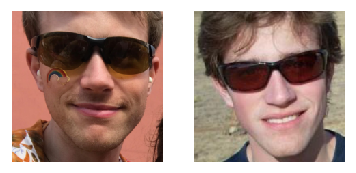

-----------------------------------------


In [49]:
id14,id30,cos,euc = verifyFace(img14,img30,vgg_face_descriptor)
id14,id31,cos,euc = verifyFace(img14,img31,vgg_face_descriptor)
id30,id31,cos,euc = verifyFace(img30,img31,vgg_face_descriptor)

<div class="span5 alert alert-success">
<p> I have now used the verifyFace function to compare the final vectors for img14, img30, img31 (PJ, AJ, AJ, respectively). These are the results:
    
   1) img14 (PJ) vs img30 (AJ) --> same person [INCORRECT]
   
   2) img14 (PJ) vs img31 (AJ) --> different person [CORRECT]
   
   3) img30 (AJ) vs img31 (AJ) --> same person [CORRECT]

Curiously, the model can tell that img14 is different from img31, and that img30 is img31, but NOT that img14 is different from 30.

   </p>
</div>


<div class="span5 alert alert-success">
<p> Below is a plot of the 3 final layer vectors associated with each of the 3 images from above. Qualitatively, there is significant similarity between the red and green lines (img14, img30), which makes sense based on the misclassification.
   </p>
</div>


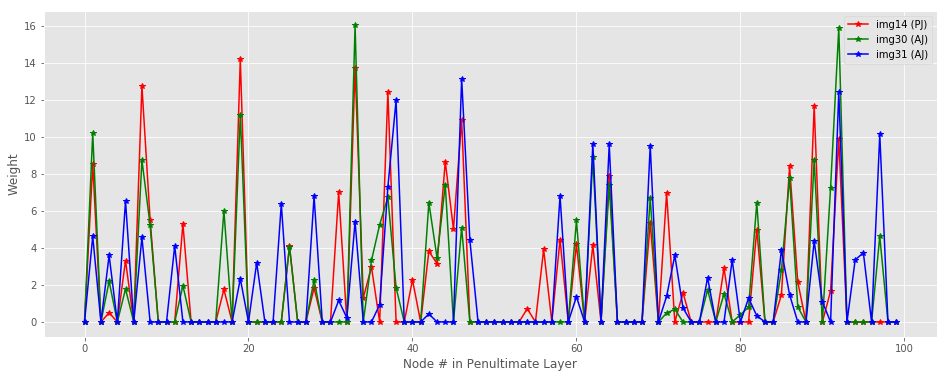

In [21]:
fig = plt.figure(figsize=(16, 6))
plt.plot(range(0,100),id14,color='r',marker='*')
plt.plot(range(0,100),id30,color='g',marker='*')
plt.plot(range(0,100),id31,color='b',marker='*')
plt.legend(['img14 (PJ)','img30 (AJ)','img31 (AJ)'])
plt.xlabel('Node # in Penultimate Layer')
plt.ylabel('Weight')
plt.show()

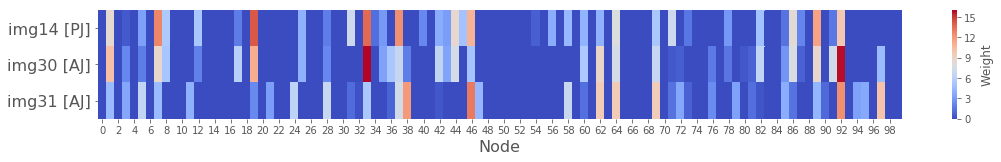

In [73]:
# Illustrated another way
combo = [id14, id30, id31]
fig = plt.figure(figsize=(18, 2))
ax = sns.heatmap(combo,cmap = 'coolwarm',yticklabels=['img14 [PJ]','img30 [AJ]','img31 [AJ]'])
plt.yticks(rotation=0,size=16) 
plt.xlabel('Node',size=16)
ax.collections[0].colorbar.set_label("Weight")

<div class="span5 alert alert-success">
<p> 
Overall, it's clear that sunglasses is a challenge for the model, but only sometimes. An 88% success rate is still quite good, especially identical twins.
   </p>
</div>
